# Face recognition using k-Nearest Neighbor

---

### Contents
<ol>
    <li><a href="#data-preprocessing" style="color: currentColor">Data preprocessing</a></li>
    <li><a href="#pca" style="color: currentColor">Principal Component Analysis</a></li>
    <li><a href="#knn" style="color: currentColor">k-Nearest-Neighbor</a></li>
    <li><a href="#testing" style="color: currentColor">Model testing</a></li>
    <li><a href="#accuracy" style="color: currentColor">Algorithm evaluation</a></li>
    <li><a href="#further-analysis" style="color: currentColor">Further Analysis</a></li>
</ol>
<br>

<i> Note: To keep the notebook readable, it focuses on executing the code and showing the results and evaluation. The entire code can be found in the functions folder and the beloging .py files.
In section 5 evaluations in order to optimize our output are performed. In Section 1-4 the model runs for demonstration, using the best parameters based on the evaluations below. Therefore, this section will show why the chosen parameters are the best for our Image analysis model.</i>

---

### Libraries

In [75]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

---

## <a id="data-preprocessing"></a> 1. Data preprocessing 

In the first part, we need to perform different preprocessing steps before we can move on to Principal component analysis (PCA).\
First, we transform each image into a 1D vector to create a 2D data matrix where each row is a single sample (image) and each column corrresponds to one feature (pixel). This procedure is called <b> flattening</b>.\
Secondly, we <b> convert the integer formats to floating point</b> so that arithmetic operations behave correctly and <b> normalize </b> the data to the range [0,1] to ensure that each pixel has a similar scale.\
Before performing further preprocessing steps, we split the dataset into training and test data. The dataset contains 11 images expressing different facial expression and light conditions of 15 subjects each. In order to split these images, 8 images of each subject are choosen randomly to use for training. All remaining images will serve as test data.
Next, we <b> center our data </b> . This is done, by subtracting the mean value for each pixel position across the dataset. This ensures that your dataset has a zero mean, which is essential because PCA will then capture the directions of maximum variance around this mean.\
Lastly, we <b> standardize</b>  the data by subtracting the mean and then dividing by the standard deviation for each feature (also called <b> z-transformation</b>).

In [79]:
from functions.preprocessing import preprocessing

# Path to the dataset folder. os.getcwd() gets the current working directory (in our case main.ipynb).
# If The dataset folder is one level up from the current working directory,  use "../" before "datasets".
folder_path = os.path.join(os.getcwd(), "datasets")
seed = 527
split_tt_ratio = 8/11

final_train, train_labels, final_test, test_labels, test_arr = preprocessing(folder_path, seed, split_tt_ratio)

Total training images: 120
Total testing images: 45


---

## <a id="pca"></a> 2. Pricinpal component analysis

In [121]:
from functions.pca import svd_pca
from functions.pca import pca_transform

n_components = 26

projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train,n_components)

test_reduced = pca_transform(final_test,projection_matrix)

Succesfully reduced Matrix from (120, 77760) to (120, 26)

Succesfully transformed Matrix from (45, 77760) to (45, 26)


---

## <a id="knn"></a> 3. k-Nearest-Neighbor

k-NN Classification Accuracy: 77.78%


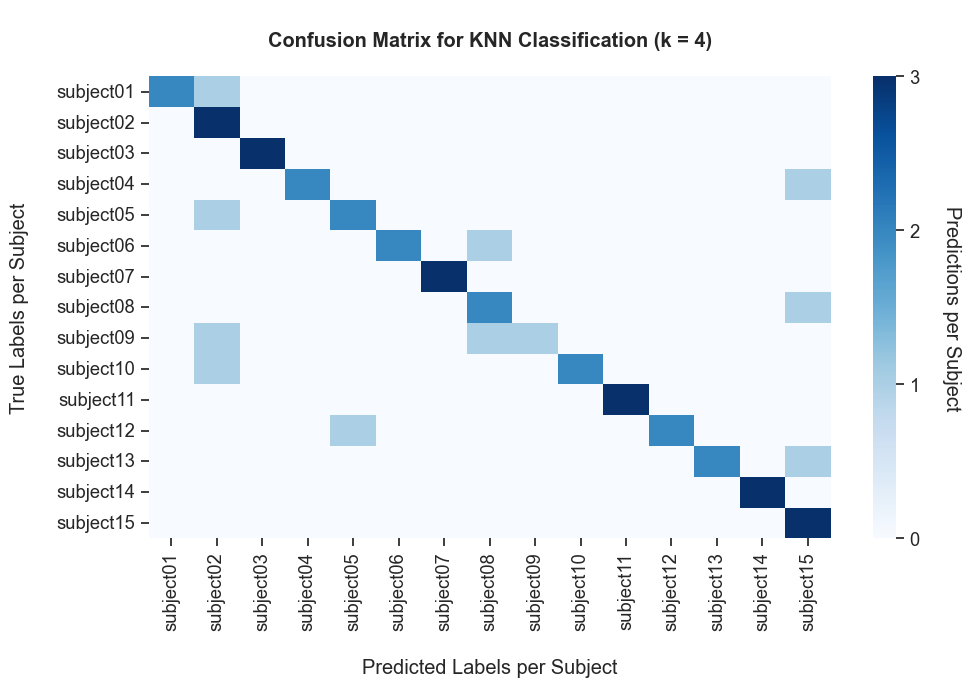

In [122]:
from functions.knn import knn_classifier

# Number of neighbors to consider
k = 4
predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k)

# Convert them to NumPy arrays if they aren’t already:
true_labels = np.array(test_labels)
pred_labels = np.array(predictions)

# Compute the confusion matrix. It will have shape (n_classes, n_classes)
cm = confusion_matrix(true_labels, pred_labels)

#Determine unique class labels for better tick labeling
classes_labels = np.unique(np.concatenate((true_labels, pred_labels)))

# Define a custom palette with soft blue tones
#custom_palette = sns.color_palette(["#ffffff", "#87CEFA", "#3A84C0", "#001f3f"], as_cmap=True)

plt.figure(figsize=(11, 6))
heatmap = sns.heatmap(cm, cmap="Blues", xticklabels=classes_labels, yticklabels=classes_labels)

# Customize the colorbar annotations
cbar = heatmap.collections[0].colorbar
# Set specific tick positions
cbar.set_ticks([0, 1, 2, 3]) 
# Labelpad is used to adjust the distance of the label from the colorbar
cbar.set_label("Predictions per Subject", rotation=270, labelpad=30)

plt.xlabel('\nPredicted Labels per Subject')
plt.ylabel('True Labels per Subject\n')
plt.title(label=f"\nConfusion Matrix for KNN Classification (k = {k})\n", fontweight='bold')
plt.show()

---

## <a id="testing"></a> 4. Model testing

In [ ]:
img_check = Image.open("datasets/subject01.glasses.gif")
print(f"Size: {img_check.size}")

In [ ]:
# first we rescale the image to the original size of the training images
image_height = 243
image_width = 320
original_shape_test_images = test_arr.reshape(-1, image_height, image_width)
print(f"final_test shape: {test_arr.shape}")
print(f"test_images original shape: {original_shape_test_images.shape}")

# Determine misclassified indices
#zipping the true labels and predictions to find misclassified images
misclassified_indices = [i for i, (true, pred) in enumerate(zip(test_labels, predictions)) if true != pred]
# Print the number of misclassified images and their indices
print(f"Total misclassified images found: {len(misclassified_indices)}")
print(misclassified_indices)
# Let's plot up to 16 misclassified images (or fewer if not available)
num_to_plot = min(16, len(misclassified_indices))
# for this a plot with subplots is created
plt.figure(figsize=(12, 12))
for idx, mis_idx in enumerate(misclassified_indices[:num_to_plot]):
    plt.subplot(4, 4, idx+1)
    plt.imshow(original_shape_test_images[mis_idx], cmap='gray') # assuming grayscale images
    plt.title(f"True: {test_labels[mis_idx]}\nPredicted: {predictions[mis_idx]}")
    plt.axis('off')
#plt.subtitle("Misclassified Test Images", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

---

## <a id="accuracy"></a> 5. Algorithm evaluation

### 5.1 How much Variance is explained by each PC?

First of all, we now want to define a Threshold as a basis to decide how much pricipal components (PC) we want to include in our analysis. We decided to use 90 % of Variance, as up to this value the curve increased exponentially and then started to flat and grows at a slower rate. Therefore we choose 26 PCs. The curve shows a horizontal asymptotic behavior. Choosing a "low" amount of PCs means also faster processing.

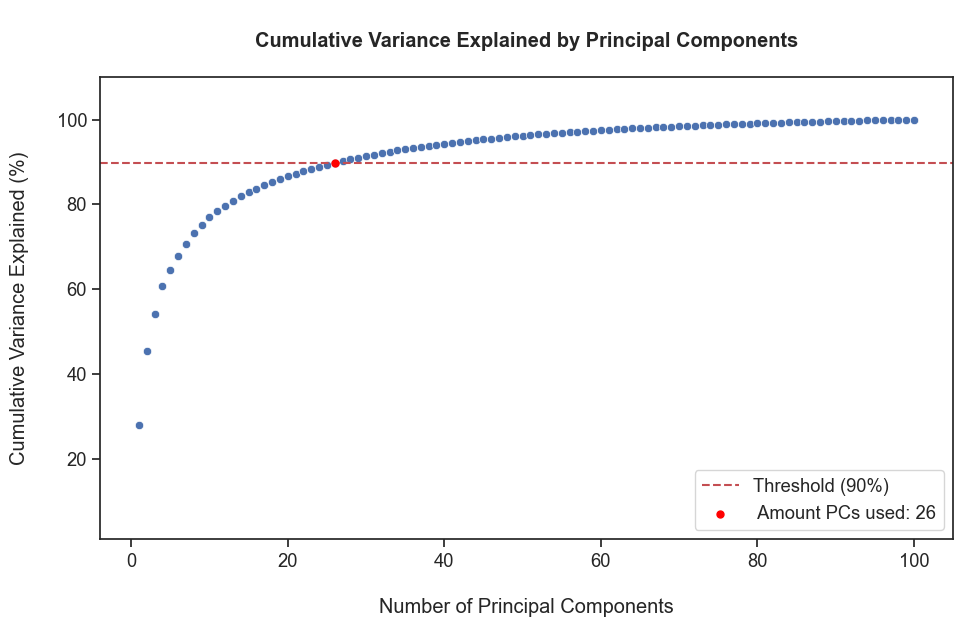

In [126]:
projection_matrix_for_plot, train_reduced_for_plot, explained_variance_ratio_for_plot = svd_pca(final_train,100, verbose = False)

n_pcs_for_plot = np.arange(1, 101)  # Range of components from 1 to 100

# times 100 to convert to percentage
cumulative_variance = np.cumsum(explained_variance_ratio_for_plot*100)

# We subtract 1 from n_components because python uses 0-based indexing
highlight_n_plot_y = cumulative_variance[n_components-1]

sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.scatterplot(x=n_pcs_for_plot, y=cumulative_variance, marker = "o")

plt.xlabel("\nNumber of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)\n")
plt.title(label="\nCumulative Variance Explained by Principal Components\n", fontweight='bold')
plt.axhline(y=highlight_n_plot_y, color='r', linestyle='--', label="Threshold (90%)")
plt.scatter(n_components, highlight_n_plot_y, color="red", s=25, zorder=2, label=f" Amount PCs used: {n_components}")
plt.legend(loc = "lower right")
plt.ylim(1, 110)
plt.show()

### 5.1.2 Accuracy vs. PC

In [ ]:
from functions.preprocessing import preprocessing
from functions.knn import knn_classifier

# How does the number of principal components affect the accuracy of the model?
pc_range = np.arange(1, 30, 1)

accuracies = []

for pc in pc_range:
    final_train, train_labels, final_test, test_labels, test_arr = preprocessing(folder_path, seed, split_tt_ratio, verbose=False)

    projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train, pc, verbose=False)

    test_reduced = pca_transform(final_test, projection_matrix, verbose=False)

    predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k=4, verbose=False)
    accuracy = np.mean(np.array(predictions) == np.array(test_labels))
    accuracies.append(accuracy)


# Plot the accuracies
df = pd.DataFrame({
    'Amount of Principal Components': pc_range,
    'Accuracy (%)': np.array(accuracies) * 100
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(11, 6))
sns.scatterplot(data=df, x='Amount of Principal Components', y='Accuracy (%)', marker='o')
plt.title("Accuracy of KNN Classifier with Different Amounts of Principal Components")
plt.ylim(0, 100)
plt.tight_layout()

### 5.2  Determining the Best Train/Test Data Ratio

For small datasets, the results may also depend on the way you choose to split the dataset. We need to use a certain amount of training images, so that the model recongnizes most of the unseen test images correctly. If no suffienct amount training data per subject is provided, KNN performs poorly, because not enough data was provided to learn, in our case to create sufficient cluster, where our images can be assigned to. Too much training data may also lead to poor results, especially for small datasets, as this can result in high variance and limited validation options.

Therefore, following plot shows the KNN accuracy for all possible Train/Test Ratios for different k from 1 to 5. The same random seed (Number 527) was used as before in Section 1. For this seed a 70/30 ratio shows highest accuracy for all k's.

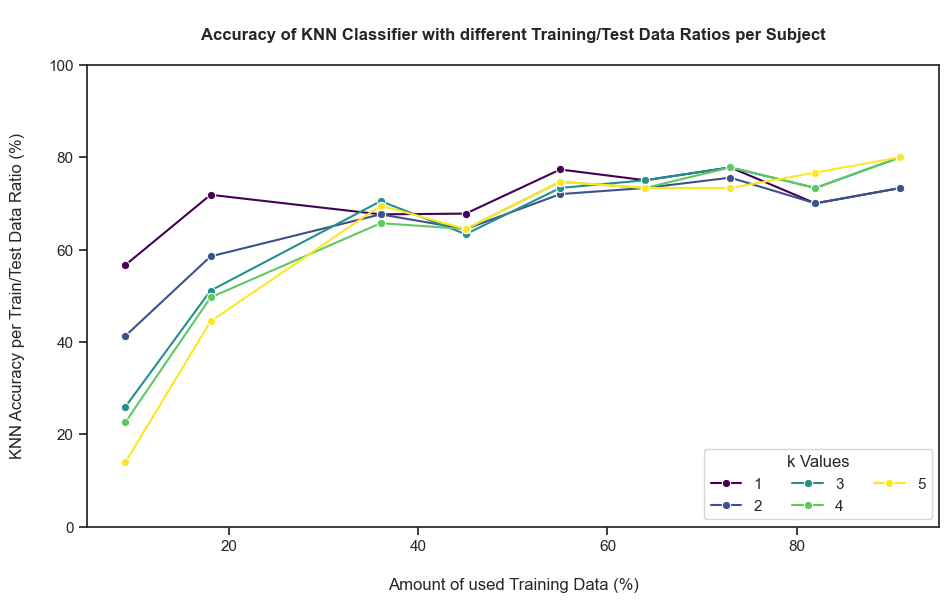

In [135]:
train_test_ratios = [1/11, 2/11, 4/11, 5/11, 6/11, 7/11, 8/11, 9/11, 10/11]

# Store results for each k value separately
df_list = []  # This will hold multiple DataFrames for different k values

for k_split in range(1,6):
    # Reset accuracies for each k_split iteration
    train_test_accuracies = []
    # loop through a
    for train_test_ratio in train_test_ratios:
        final_train_split, train_labels_split, final_test_split, test_labels_split, test_arr = preprocessing(folder_path, seed, train_test_ratio, verbose=False)

        projection_matrix_split, train_reduced_split, explained_variance_ratio_split = svd_pca(final_train_split, n_components, verbose=False)

        test_reduced_split = pca_transform(final_test_split, projection_matrix_split, verbose=False)

        predictions_split = knn_classifier(train_reduced_split, train_labels_split, test_reduced_split, test_labels_split, k_split, verbose=False)
        accuracy_split = np.mean(np.array(predictions_split) == np.array(test_labels_split))
        train_test_accuracies.append(accuracy_split)
    df_split = pd.DataFrame({
        # Add k_split identifier
        "K Value": [k_split] * len(train_test_ratios),
        "Amount of Training Data (%)": [round(r * 100) for r in train_test_ratios],
        "KNN Accuracy per Train/Test Ratio (%)": [round(a * 100, 2) for a in train_test_accuracies]
    })
    df_list.append(df_split)  # Store DataFrame for this k_split

# Append results to the combined DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Get the index of the highest accuracy
max_index_split = df_combined['KNN Accuracy per Train/Test Ratio (%)'].idxmax()

# Extract the best splitting and its accuracy
best_split = df_combined.loc[max_index_split, 'Amount of Training Data (%)']
highest_acc_split = df_combined.loc[max_index_split, 'KNN Accuracy per Train/Test Ratio (%)']

#custom_palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
plt.figure(figsize=(11, 6))
sns.lineplot(data=df_combined, x="Amount of Training Data (%)",
              y="KNN Accuracy per Train/Test Ratio (%)",
              hue="K Value", palette = "viridis", marker="o")
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with different Training/Test Data Ratios per Subject\n", fontweight='bold')
plt.xlabel("\nAmount of used Training Data (%)")
plt.ylabel("KNN Accuracy per Train/Test Data Ratio (%)\n")
#plt.xticks(list(plt.xticks()[0]) + [best_split])
#plt.axvline(best_split, color="r", linestyle = "--",
           # label = f"{best_split} / {100-best_split} (%) (Train/Test)")
plt.ylim(0, 100)
plt.legend(title="k Values", ncol=3, loc= "lower right")
plt.show()

### 5.3 Determining best k

Using Build-In functions from sklearn, we want to find the best k by evaluating accuracy-, precision-, recall- and f1- score combined with K-fold cross validation. This ensures that we choose our k with robust parameters, which is important for small datasets, as variance may affect the results e.g. Hold-out validation is used. K-fold cross validation evaluates the model performance by splitting the dataset multiple times in training and validation sets. More precisely it splits the dataset into k subsets (folds), trains the model k times, each time using k-1 folds for training and 1 fold for testing and averages the results from all k runs to get a final performance score.

Stratified k-Fold, a specific type of k-fold cross validation, is used to ensure class distribution remains balanced across folds, which is very important for classification tasks like face recognition. We train the model 5 times (5-fold), as this is widely used in scientific work (Diebold, F.X. (2014)). We use 120 training images for this approach (~70/30 Splitting of our dataset), to have left 45 unseen test images, which showed, that the estimated parameter k truly perform well as shown in sections 1-4.

To determine k even better, further scores were determined too, as mentioned in the beginning. **Text ergänzen**

In [ ]:
# Candidate k values for the KNN classifier.
ev_k_values = range(1,11)

# List to gather results for each candidate k.
results_ev = []

# Initialize StratifiedKFold to preserve class distribution in each fold.
# random_state ist der seed mit dem gesplittet wird => ÄNDERN!!!!!!!!!!
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=83)

# Loop over the candidate k values.
for k_val in ev_k_values:
    # Lists to store metric scores for each fold.
    fold_acc = []
    fold_prec = []
    fold_rec = []
    fold_f1 = []

    # Perform the cross-validation.
    for train_index, test_index in skf.split(train_reduced, train_labels):
        # Create training and testing splits based on the indices.
        X_train, X_test = train_reduced[train_index], train_reduced[test_index]
        y_train, y_test = np.array(train_labels)[train_index], np.array(train_labels)[test_index]

        # Initialize and train the KNN classifier with the current k.
        y_pred = knn_classifier(X_train,y_train, X_test, y_test, k_val, verbose=False)

        # Compute evaluation metrics for the current fold.
        fold_acc.append(accuracy_score(y_test, y_pred))
        fold_prec.append(precision_score(y_test, y_pred, average="weighted", zero_division=0))
        fold_rec.append(recall_score(y_test, y_pred, average="weighted", zero_division=0))
        fold_f1.append(f1_score(y_test, y_pred, average="weighted", zero_division=0))

    # Compute mean scores across all folds.
    mean_acc = np.mean(fold_acc)
    mean_prec = np.mean(fold_prec)
    mean_rec = np.mean(fold_rec)
    mean_f1 = np.mean(fold_f1)

    # Append the results for the current k into our list as a dictionary.
    results_ev.append({
        "k": k_val,
        "accuracy": mean_acc,
        "precision": mean_prec,
        "recall": mean_rec,
        "f1": mean_f1
    })

# Convert the list of dictionaries into a Pandas DataFrame.
results_ev_k = pd.DataFrame(results_ev)
# Print out the DataFrame.
print(results_ev_k)

    k  accuracy  precision    recall        f1
0   1  0.750000   0.772222  0.750000  0.731389
1   2  0.750000   0.790278  0.750000  0.744167
2   3  0.733333   0.769444  0.733333  0.714444
3   4  0.733333   0.766944  0.733333  0.714167
4   5  0.725000   0.760833  0.725000  0.710079
5   6  0.716667   0.744444  0.716667  0.693889
6   7  0.700000   0.716667  0.700000  0.676389
7   8  0.700000   0.704167  0.700000  0.671944
8   9  0.666667   0.684028  0.666667  0.642222
9  10  0.666667   0.652778  0.666667  0.628333


The results show, that k = 1 and 2 perform best considering all parameters. As k = 1 is very sensitive to noise (e.g. single outliers) and prediction is based on just the closest sample, minor variations in the dataset (like different train-test splits or seeds) can cause big changes in accuracy. Additionally, overfitting might also be a problem here.

Therefore we it would make sense to proceed with the other best k, k = 2. Nevertheless the following plot shows, that k = 4 has the highest KNN-Accuracy score for the test images from our dataset. This shows that for real world output can differ from model evaluation techniques,  especially for small datasets. Therefore also accuracy percentage differs, which is due to the dataset size, as small changes in data distribution can significantly impact accuracy. Also Stratified k-Fold averages the results, meaning that it performs slightly better or worse in different folds.

Evaluation of best k for:
120 training images and 45 test images and 26 principal components

Best k = 1 with accuracy: 77.78%


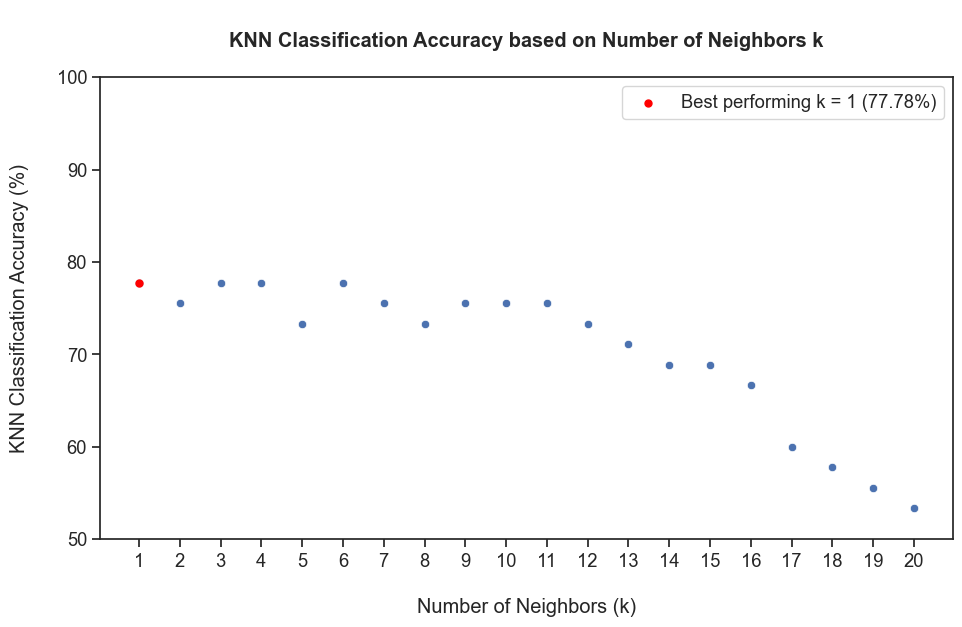

In [138]:
# Dictionary to store accuracies for each k value.
accuracy_dict = {}

#\033[1m stands for bold;\033[3m stands for italic \033[0m resets the formatting to normal.
print(f"Evaluation of best \033[3m\033[1mk\033[0m for:")
print(f"\033[3m\033[1m{len(train_reduced)}\033[0m training images and \033[3m\033[1m{len(test_reduced)}\033[0m test images and \033[3m\033[1m{n_components}\033[0m principal components")

# loop through k values from 1 to 20
for k in range(1, 21):
    predicted_labels = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k, verbose=False)
    accuracy = np.mean(np.array(predicted_labels) == np.array(test_labels))
    # assigns the value of accuracy to the key k in the dictionary accuracy_dict.
    # This means for each value of k (the number of neighbors in KNN), you store the corresponding classification accuracy.
    accuracy_dict[k] = accuracy

# Identify the best k value based on the highest accuracy
best_k = max(accuracy_dict, key=accuracy_dict.get)
highest_accuracy = accuracy_dict[best_k]*100
print(f"\nBest k = {best_k} with accuracy: \033[1m{highest_accuracy:.2f}%\033[0m")

# First, sort the dictionary keys (k values) for plotting in order.
k_values = sorted(accuracy_dict.keys())
k_accuracy_values = [accuracy_dict[k]*100 for k in k_values]


sns.set_theme(style="ticks", font_scale=1.2)
plt.figure(figsize=(11, 6))
sns.scatterplot(x=k_values, y=k_accuracy_values, marker='o')

plt.xlabel("\nNumber of Neighbors (k)")
plt.ylabel("KNN Classification Accuracy (%)\n")
plt.title(label="\nKNN Classification Accuracy based on Number of Neighbors k\n", fontweight='bold')
plt.scatter(best_k, highest_accuracy, color="red", s=25, zorder=2, label=f"Best performing k = {best_k} ({highest_accuracy:.2f}%)")
plt.legend()
plt.ylim(50, 100)
plt.xticks(np.arange(1,21, 1))
plt.show()

### 5.2 Seed performance

In [ ]:
from functions.evaluation import preprocessing_seed

# Lets run the KNN classifier with different random seeds to see how the accuracy changes.
seeds = np.array(range(40,43))

accuracies = []

for seed in seeds:
    final_train, train_labels, final_test, test_labels = preprocessing_seed(seed)

    projection_matrix, train_reduced, explained_variance_ratio = svd_pca(final_train, n_components, verbose=False)

    test_reduced = pca_transform(final_test, projection_matrix, verbose=False)

    predictions = knn_classifier(train_reduced, train_labels, test_reduced, test_labels, k=3, verbose=False)
    accuracy = np.mean(np.array(predictions) == np.array(test_labels))
    accuracies.append(accuracy)

df_seed = pd.DataFrame({
    'Seed': seeds,
    'KNN Accuracy per seed (%)': np.array(accuracies) * 100
})

# Get the index of the highest accuracy
max_index = df_seed['KNN Accuracy per seed (%)'].idxmax()

# Extract the best seed and its accuracy
best_seed = df_seed.loc[max_index, 'Seed']
highest_acc_seed = df_seed.loc[max_index, 'KNN Accuracy per seed (%)']

plt.figure(figsize=(11, 6))
sns.scatterplot(data=df_seed, x='Seed', y='KNN Accuracy per seed (%)', marker='o')
sns.set_theme(style="ticks")

plt.title("\nAccuracy of KNN Classifier with Different Random Seeds\n", fontweight='bold')
plt.scatter(best_seed, highest_acc_seed, color="red", s=25, zorder=2, 
            label=f"Best seed: {best_seed} ({highest_acc_seed:.2f}%)")
plt.xlabel("\nSeed Number")
plt.ylabel("KNN Accuracy per seed (%)\n")
plt.legend()
plt.ylim(0, 100)
plt.tight_layout()

---

## <a id="further-analysis"></a> 6. Further analysis

In [ ]:
# for MacOS users, the path separator is a forward slash, please uncomment the following line:
# %run functions/furtheranalysis.py

%run functions\furtheranalysis.py